Neste notebook, iremos explorar várias arquiteturas de redes neurais recorrentes (RNNs). Vamos começar baixando os dados do clima da cidade de Jena, na Alemanha, de 2009 a 2016.


In [1]:
! wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
! unzip jena_climate_2009_2016.csv.zip

--2025-04-03 01:16:55--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.15.177.210, 52.217.234.120, 54.231.162.208, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.15.177.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  63.2MB/s    in 0.2s    

2025-04-03 01:16:55 (63.2 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


Vamos ler o arquivo, linha por linha, separando cada variável pela vírgula. Esse é um "programa" meio padrão de leitura em Python. Atualmente, há maneiras de ler diretamente arquivos csv e xslx com o Pandas, por exemplo.

In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")
with open(fname) as f:
  data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


Agora iremos salvar os valores de temperatura e os dados brutos em um array do Python.

In [3]:
import numpy as np
temperature = np.zeros((len(lines)))
raw_data = np.zeros((len(lines), len(header) -1 ))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(",")[1:]]
  temperature[i] = values[1]
  raw_data[i, :] = values[:]

In [22]:
raw_data

array([[ 0.91365151, -1.92064015, -1.97449272, ..., -0.73016651,
        -0.77935289, -0.28119316],
       [ 0.91953033, -1.96510495, -2.01848295, ..., -0.93230685,
        -0.88696976, -0.46989368],
       [ 0.91482727, -1.97650618, -2.0297625 , ..., -1.27790162,
        -1.26147647, -0.05638329],
       ...,
       [ 1.30165361, -1.36654038, -1.45450563, ..., -0.69756323,
        -0.67173602,  0.45147737],
       [ 1.30047784, -1.48853354, -1.57519677, ..., -0.43021634,
        -0.60286122,  0.57494808],
       [ 1.30165361, -1.5558008 , -1.64061814, ..., -0.59975339,
        -0.68895472,  0.09853751]])

In [23]:
raw_data.shape

(420451, 14)

Usamos o matplotlib para plotar os dados.

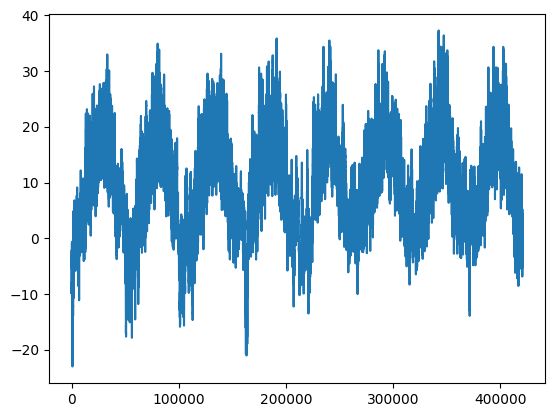

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

Podemos plotar os dados dos dez primeiros dias para ter uma visão melhor da variação de temperatura. Neste conjunto de dados, as medidas foram feitas de 10 em 10 min, então em uma hora temos 6 medidas * 24 = 144 pontos por dia.

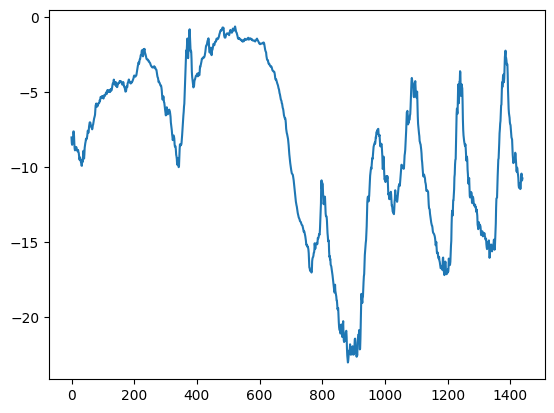

In [5]:
plt.plot(range(1440), temperature[:1440])

Agora iremos separar os dados brutos em um conjunto de treinamento, de teste e de validação. Isso é uma prática comum a todos os problemas com redes neurais (e machine learning em geral). Existem já métodos com outras bibliotecas para separar automaticamente os conjuntos, porém aqui usaremos diretamente o Python.

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


Agora escalonaremos os dados em relação a média e o desvio padrão.

In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

Agora a última parte do tratamento de dados: iremos criar uma função para criar as nossas entradas no formato correto.

Iremos usar uma ferramenta do Python chamada timeseries_dataset_from_array. A ideia é que, como uma série temporal tem vários dados reduntantes, iremos "empacotar" esses dados em conjuntos dados pelo parâmetro sequence_length.

Por exemplo, se temos data = [0 1 2 3 4 5 6] e sequence_length = 3, iremos gerar amostras [0 1 2], [1 2 3], [2 3 4], [3 4 5], [4 5 6].

Podemos também passar os alvos (targets) como argumento, mas deslocados pelo mesmo sequence_length e começando do sequence_length+1; no exemplo anterior, os alvos começariam com targets = [3 4 5 6 ...].

Usaremos os parâmetros sequence_length = 120 e sampling_rate=6, que indica que apenas um ponto dos dados será amostrado por hora; manteremos apenas um ponto em 6.

In [9]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

In [10]:
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

Vamos dar uma olhada na dimensão das amostras e alvos. Na amostra, temos um batch de 256 entradas, cada contendo 120 horas consecutivas de dados de entrada, e alvos é o array correspondente de 256 temperaturas-alvo.

In [11]:
for samples, targets in train_dataset:
  print("samples shape:", samples.shape)
  print("targets shape:", targets.shape)
  break

samples shape: (256, 120, 14)
targets shape: (256,)


Vamos primeiro prever o erro absoluto médio com um método "ingênuo", para atuar como uma linha-base, uma medida mínima de desempenho que precisaremos superar. Neste modelo, vamos prever que a temperatura em um dia será a mesma de 24h atrás.

Pegaremos o valor de 24h atrás pelo samples[:,-1,1]; já que a temperatura está na coluna 1, assim pegaremos a última medida de temperatura da nossa entrada.

Como rescalonamos nossas medidas, precisamos multiplicar pelo desvio-padrão e adicionar a média novamente.

In [12]:
def evaluate_naive_method(dataset):
  total_abs_err = 0.
  samples_seen = 0
  for samples, targets in dataset:
    preds = samples[:, -1, 1] * std[1] + mean[1]
    total_abs_err += np.sum(np.abs(preds - targets))
    samples_seen += samples.shape[0]
  return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


Agora vamos usar uma RNN, com apenas uma camada LSTM com 16 nós (ou unidades). O método callback do Keras serve para salvar o modelo. Vamos usar apenas 5 épocas, mas depois vocês podem testar com mais épocas (recomendo 10) e ver o efeito no resultado!

In [13]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=3,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 109s 131ms/step - loss: 76.2494 - mae: 6.6914 - val_loss: 13.1553 - val_mae: 2.7564
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 109s 133ms/step - loss: 12.3870 - mae: 2.7100 - val_loss: 9.6953 - val_mae: 2.4293
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 128s 156ms/step - loss: 10.0307 - mae: 2.4648 - val_loss: 9.7287 - val_mae: 2.4046
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 112s 137ms/step - loss: 9.5596 - mae: 2.4019 - val_loss: 9.7968 - val_mae: 2.4202
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 107s 130ms/step - loss: 9.1679 - mae: 2.3498 - val_loss: 9.6478 - val_mae: 2.4187
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 140s 127ms/step - loss: 8.7799 - mae: 2.3046 - val_loss: 9.7190 - val_mae: 2.4149
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 103s 126ms/step - loss: 8.4636 - mae: 2.2667 - val_loss: 10.0129 - val_mae: 2.4440
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 104s 126ms/step - loss: 8.2283 - mae: 2.2352 - val_loss: 10.8097 - val_mae: 2.4978
Epoch 9/10
819/819

Vamos plotar os resultados: o erro absoluto médio do conjunto de treinamento e de validação, e também a perda nos dois conjuntos.

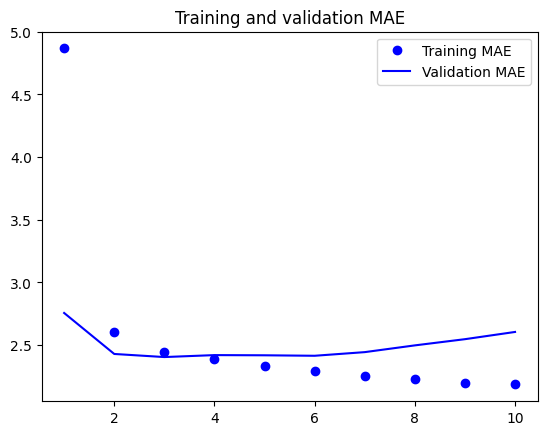

In [14]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Agora vamos ver o efeito da adição de uma camada Dropout, agora com uma camada LSTM com 32 unidades. Depois tentem rodar com mais épocas! No livro, é utilizado 50 épocas, mas levará bastante tempo.

In [16]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=3,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/3
819/819 ━━━━━━━━━━━━━━━━━━━━ 176s 210ms/step - loss: 48.8544 - mae: 5.1718 - val_loss: 9.6254 - val_mae: 2.4156
Epoch 2/3
819/819 ━━━━━━━━━━━━━━━━━━━━ 177s 216ms/step - loss: 15.1899 - mae: 3.0248 - val_loss: 9.4031 - val_mae: 2.3851
Epoch 3/3
819/819 ━━━━━━━━━━━━━━━━━━━━ 175s 214ms/step - loss: 14.5211 - mae: 2.9552 - val_loss: 9.1159 - val_mae: 2.3469
405/405 ━━━━━━━━━━━━━━━━━━━━ 35s 84ms/step - loss: 10.3282 - mae: 2.5158
Test MAE: 2.51


Novamente, vamos plotar o resultado para o modelo.

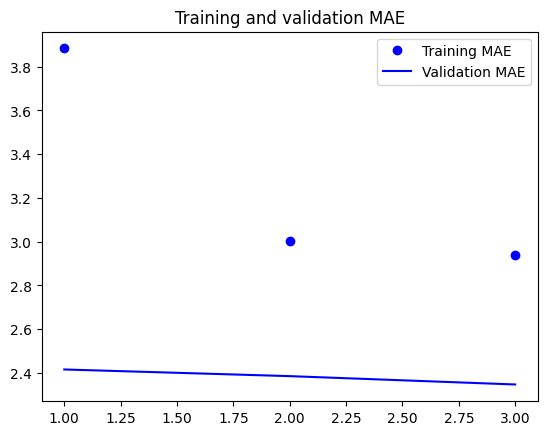

In [17]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Agora vamos usar um modelo mais refinado: Duas camadas recorrentes, cada uma com 32 unidades GRU, com dropout. Aqui irá demorar bem mais. No livro, novamente é utilizado um epochs=50.

In [18]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=3,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/3
819/819 ━━━━━━━━━━━━━━━━━━━━ 342s 407ms/step - loss: 42.9946 - mae: 4.8717 - val_loss: 9.6291 - val_mae: 2.4028
Epoch 2/3
819/819 ━━━━━━━━━━━━━━━━━━━━ 300s 366ms/step - loss: 14.5954 - mae: 2.9616 - val_loss: 8.7589 - val_mae: 2.2882
Epoch 3/3
819/819 ━━━━━━━━━━━━━━━━━━━━ 295s 360ms/step - loss: 13.6862 - mae: 2.8674 - val_loss: 9.0396 - val_mae: 2.3316
405/405 ━━━━━━━━━━━━━━━━━━━━ 51s 121ms/step - loss: 10.1256 - mae: 2.4734
Test MAE: 2.47


De novo, plotando os resultados!

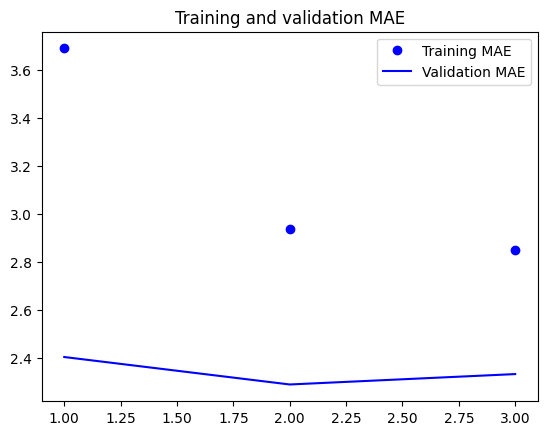

In [19]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()